# **Homework 3: Exploration of an Interesting Text Corpus**

Elizabeth Frank IST736 Text Mining Due: July 25, 2025 11:59 pm Submitted: July 25, 2025 9:30pm

---
## **Objective**
---

This project explores how much emotional and thematic information is retained in a chorus compared to an entire song. Choruses are often treated as the core or highlight of a song, so the question is whether they can stand in for full lyrics in clustering or classification tasks. Using a small, curated corpus of a total of 30 songs from Green Day, Tom Petty, and R.E.M., this analysis compares full songs and their extracted choruses across multiple text mining techniques.

The goal is to see how well choruses capture signal through unsupervised and supervised models. I apply vectorization, KMeans clustering, sentiment scoring, and logistic regression to both full song lyrics and their choruses. From there, I compare how each performs, both visually and statistically, in separating the songs into meaningful groups. This helps answer whether shorter, focused text segments like choruses can replace full lyrics in exploratory text analysis.

---
## **Dataset**
---

The dataset includes 30 songs from three artists and was compiled in an Excel file. One sheet contains the full lyrics for each song, while the second sheet isolates the chorus text. These were merged into a single working dataframe that retains artist name, song title, full lyrics, and section or text portion.

Each record includes:

**song_title**: title of the song <br>
**artist**: artist of song <br>
**section**: full_song or chorus <br>
**text** full song text <br>
**chorus** chorus text

---

### **Import Libraries**

In [90]:
# Data and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text Processing
import re
import string
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Clustering and Projection
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Modeling and Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Utilities
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### **Define Functions**


In [58]:
###Visualization Utilities

# Combined boxplot and histogram for numeric feature
def histogram_boxplot(df, feature, figsize=(8, 4), kde=False, bins=None):
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={'height_ratios': (0.25, 0.75)},
        figsize=figsize
    )
    sns.boxplot(data=df, x=feature, ax=ax_box2, showmeans=True, color='violet')
    sns.histplot(data=df, x=feature, kde=kde, ax=ax_hist2, bins=bins or 'auto')
    ax_hist2.axvline(df[feature].mean(), color='green', linestyle='--', label='Mean')
    ax_hist2.axvline(df[feature].median(), color='black', linestyle='-', label='Median')
    ax_hist2.legend()
    plt.tight_layout()
    plt.show()


### Sentiment Utilities (VADER)

# Compound VADER sentiment score and label
def raw_vader_labels(df, text_col='text'):
    sid = SentimentIntensityAnalyzer()
    df_copy = df.copy()
    df_copy['vader_score'] = df_copy[text_col].apply(lambda x: sid.polarity_scores(str(x))['compound'])
    df_copy['vader_sentiment'] = df_copy['vader_score'].apply(
        lambda score: 'pos' if score > 0 else ('neg' if score < 0 else 'neu')
    )
    return df_copy

# Aggregate sentiment proportion by artist
def artist_sentiment(df, artist_col='artist', text_col='text'):
    sid = SentimentIntensityAnalyzer()
    sentiment_data = []

    for artist, group in df.groupby(artist_col):
        sentiment_labels = [
            'pos' if sid.polarity_scores(str(text))['compound'] > 0
            else 'neg' if sid.polarity_scores(str(text))['compound'] < 0
            else 'neu'
            for text in group[text_col]
        ]
        label_counts = pd.Series(sentiment_labels).value_counts(normalize=True)
        sentiment_data.append({
            'artist': artist,
            'positive': label_counts.get('pos', 0),
            'neutral': label_counts.get('neu', 0),
            'negative': label_counts.get('neg', 0)
        })

    return pd.DataFrame(sentiment_data).set_index('artist').round(3)


### Word Cloud & Frequency Analysis

# Generate word cloud from specific column
def overall_wordcloud(df, text_col='text', colormap='PuBuGn', title='Combined Word Cloud'):
    text_data = ' '.join(df[text_col].dropna().astype(str))
    wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap=colormap).generate(text_data)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Generate word cloud by artist
def artist_wordclouds(df, text_col='text', group_col='artist', ncols=3, title_suffix=''):
    artist_colormaps = {'Green Day': 'viridis', 'REM': 'plasma', 'Tom Petty': 'cividis'}
    groups = df[group_col].unique()
    nrows = -(-len(groups) // ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
    axes = axes.flatten()

    for i, group in enumerate(groups):
        text_data = ' '.join(df[df[group_col] == group][text_col].dropna().astype(str))
        cmap = artist_colormaps.get(group, 'gray')
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=cmap).generate(text_data)
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f"{group} {title_suffix}".strip(), fontsize=14)
        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Return token frequenct counts from text
def get_token_frequencies(text_series):
    text = ' '.join(text_series.dropna().astype(str))
    tokens = re.findall(r'\b\w+\b', text.lower())
    return Counter(tokens)

# Compare token frequency between song and chorus by artist
def artist_nonchorus_diff_freqs(df, text_col='text', chorus_col='chorus', group_col='artist'):
    diff_dict = {}
    for artist in df[group_col].unique():
        subset = df[df[group_col] == artist]
        song_freq = get_token_frequencies(subset[text_col])
        chorus_freq = get_token_frequencies(subset[chorus_col])

        diff_freq = {word: song_freq[word] - chorus_freq.get(word, 0)
                     for word in song_freq if song_freq[word] > chorus_freq.get(word, 0)}
        diff_dict[artist] = diff_freq

    return diff_dict

# Generate word cloud by word frequency by artist
def plot_artist_diff_wordclouds(diff_dict, colormaps=None, title_suffix=''):
    artists = list(diff_dict.keys())
    colormaps = colormaps or ['cividis', 'plasma', 'viridis']
    fig, axes = plt.subplots(1, len(artists), figsize=(6 * len(artists), 5))

    for i, artist in enumerate(artists):
        wc = WordCloud(width=800, height=400, background_color='white',
                       colormap=colormaps[i % len(colormaps)]).generate_from_frequencies(diff_dict[artist])
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(f"{artist} {title_suffix}", fontsize=14)

    plt.tight_layout()
    plt.show()

### **Import Data**

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Load the dataset from original pull
song_df = pd.read_excel("/content/drive/MyDrive/Syracuse/IST 736 Text Mining/Homework 3/TM_Songs.xlsx", sheet_name="full_songs")
chorus_df = pd.read_excel("/content/drive/MyDrive/Syracuse/IST 736 Text Mining/Homework 3/TM_Songs.xlsx", sheet_name="chorus")

# Create a copy and combine
combined_df = song_df.copy()
combined_df['chorus'] = chorus_df['text']
combined_df = combined_df.drop(columns='section')

**Explanation:**

The dataset was created manually by extracting the chorus from each song obtained from azlyrics.com and placing it alongside the full lyrics in an Excel file. Because chorus boundaries vary and are not explicitly marked, this step required manual and nuanced review. Both sheets were then loaded and merged into a single dataframe for analysis.

###**Data Overview**

In [ ]:
# Preview the full song dataframe
song_df.head()

,song_title,artist,section,text
0,Free Fallin',Tom Petty,full_song,"She's a good girl, loves her mama Loves Jesus ..."
1,I Won't Back Down,Tom Petty,full_song,"Well, I won't back down No, I won't back down ..."
2,American Girl,Tom Petty,full_song,"Well, she was an American girl Raised on promi..."
3,Learning to Fly,Tom Petty,full_song,"Well, I started out down a dirty road Started ..."
4,You Don't Know How It Feels,Tom Petty,full_song,Let me run with you tonight I'll take you on a...


In [ ]:
# Check full posts for data clarity
pd.set_option('display.max_colwidth', None)
song_df[['song_title', 'artist', 'text']].sample(3, random_state=3)

,song_title,artist,text
15,Shiny Happy People,REM,"Shiny happy people laughing Meet me in the crowd, people, people Throw your love around, love me, love me Take it into town, happy, happy Put it in the ground where the flowers grow Gold and silver shine Shiny happy people holding hands Shiny happy people holding hands Shiny happy people laughing Everyone around, love them, love them Put it in your hands, take it, take it There's no time to cry, happy, happy Put it in your heart where tomorrow shines Gold and silver shine Shiny happy people holding hands Shiny happy people holding hands Shiny happy people laughing Whoa, here we go Shiny happy people holding hands Shiny happy people holding hands Shiny happy people laughing Shiny happy people holding hands Shiny happy people holding hands Shiny happy people laughing Shiny happy people holding hands Shiny happy people holding hands Shiny happy people laughing Shiny happy people holding hands People, happy people People"
5,Don’t Do Me Like That,Tom Petty,"I was talking with a friend of mine, said a woman had hurt his pride Told him that she loved him so and turned around and let him go Then he said, ""You better watch your step Or you're gonna get hurt yourself Someone's gonna tell you lies, cut you down to size"" Don't do me like that Don't do me like that What if I love you baby? Don't do me like that Don't do me like that Don't do me like that Someday I might need you, baby Don't do me like that Listen honey, can you see? Baby, it would bury me If you were in the public eye givin' someone else a try And you know you better watch your step Or you're gonna get hurt yourself Someone's gonna tell you lies, cut you down to size Don't do me like that Don't do me like that What if I love you baby? Don't, don't, don't, don't Don't do me like that Don't do me like that What if I need you baby? Don't do me like that 'Cause somewhere deep down inside Someone is saying, ""Love doesn't last that long"" I've had this feelin' inside night and day in And baby I can't take it no more Listen honey, can you see? Baby, it would bury me If you were in the public eye givin' someone else a try And you know you better watch your step Or you're gonna get hurt yourself Someone's gonna tell you lies, cut you down to size Don't do me like that Don't do me like that What if I love you baby? Don't, don't, don't, don't Don't do me like that Don't do me like that I just might need you honey Don't do me like that Wait! Don't do me like that Don't do me like that Baby, baby, baby, Don't, don't, don't No! Don't do me like that Don't do me like that Baby, baby, baby... Oh, oh, oh"
22,When I Come Around,Green Day,"I heard you crying loud, All the way across town You've been searching for that someone, And it's me out on the prowl As you sit around feeling sorry for yourself Well, don't get lonely now And dry your whining eyes I'm just roaming for the moment Sleazin' my back yard so don't get so uptight You been thinking about ditching me No time to search the world around Cause you know where I'll be found When I come around I heard it all before So don't knock down my door I'm a loser and a user so I don't need no accuser To try and slag me down because I know you're right So go do what you like Make sure you do it wise You may find out that your self-doubt means nothing Was ever there You can't go forcing something if it's just Not right No time to search the world around Cause you know where I'll be found When I come around No time to search the world around Cause you know where I'll be found When I come around When I come around When I come around When I come around"


In [ ]:
# Reset column width to default
pd.reset_option('display.max_colwidth')

In [ ]:
# Preview combined dataframe
combined_df.head()

,song_title,artist,text,chorus
0,Free Fallin',Tom Petty,"She's a good girl, loves her mama Loves Jesus ...","Now I'm free, free fallin' (Free fallin', I'm-..."
1,I Won't Back Down,Tom Petty,"Well, I won't back down No, I won't back down ...","(I won't back down) Hey, baby There ain't no e..."
2,American Girl,Tom Petty,"Well, she was an American girl Raised on promi...","Oh yeah, all right Take it easy, baby Make it ..."
3,Learning to Fly,Tom Petty,"Well, I started out down a dirty road Started ...",I'm learning to fly (Learning to fly) But I ai...
4,You Don't Know How It Feels,Tom Petty,Let me run with you tonight I'll take you on a...,So let's get to the point Let's roll another j...


In [ ]:
# Shape and columns
print("Shape:", combined_df.shape)
print("Columns:", combined_df.columns.tolist())

Shape: (30, 4)
Columns: ['song_title', 'artist', 'text', 'chorus']


**Observation:**

The combined dataframe now contains 30 rows and four columns: song_title, artist, text, and chorus. Each row represents a single song, with both the full lyrics, and chorus stored side by side.

In [61]:
# Calculate word count for each text
song_df['word_count'] = song_df['text'].apply(lambda x: len(x.split()))
chorus_df['word_count'] = chorus_df['text'].apply(lambda x: len(x.split()))

# Generate descriptive statistics for each type
song_stats = song_df['word_count'].describe()
chorus_stats = chorus_df['word_count'].describe()

summary_df = pd.DataFrame({
    'full song': song_stats,
    'chorus': chorus_stats
})
summary_df

,full song,chorus
count,30.000000,30.000000
mean,240.200000,24.700000
std,92.862301,10.269305
min,153.000000,12.000000
25%,181.000000,18.000000
50%,216.000000,23.000000
75%,259.500000,29.250000
max,604.000000,59.000000


**Observation:**

Full songs are significantly longer than choruses. The average word count for a full song is 240, while the average chorus is 25 words, approximately a tenth of the length. The difference is consistent across the range: the minimum full song length is 153 words, well above the maximum chorus length 59 words.

### **Exploratory Data Anaylsis**

Full Song Word Count Distribution


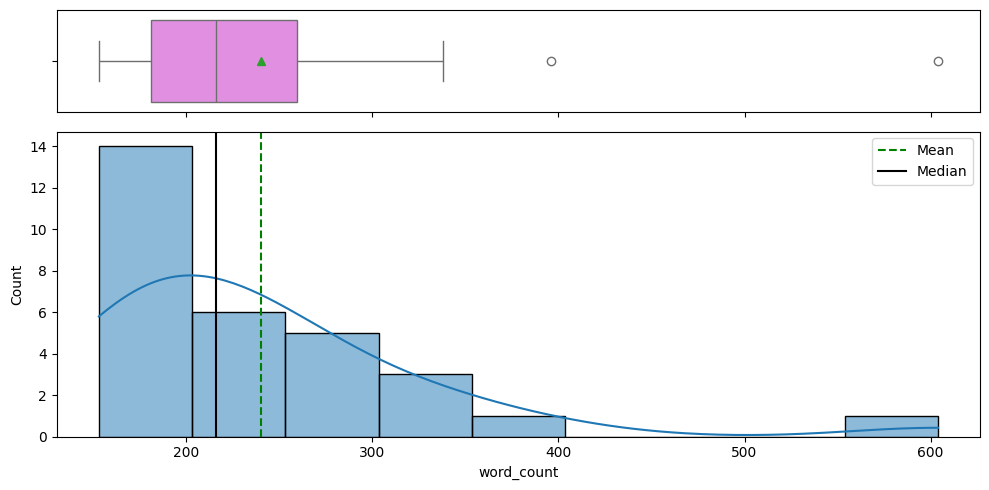

Chorus Word Count Distribution


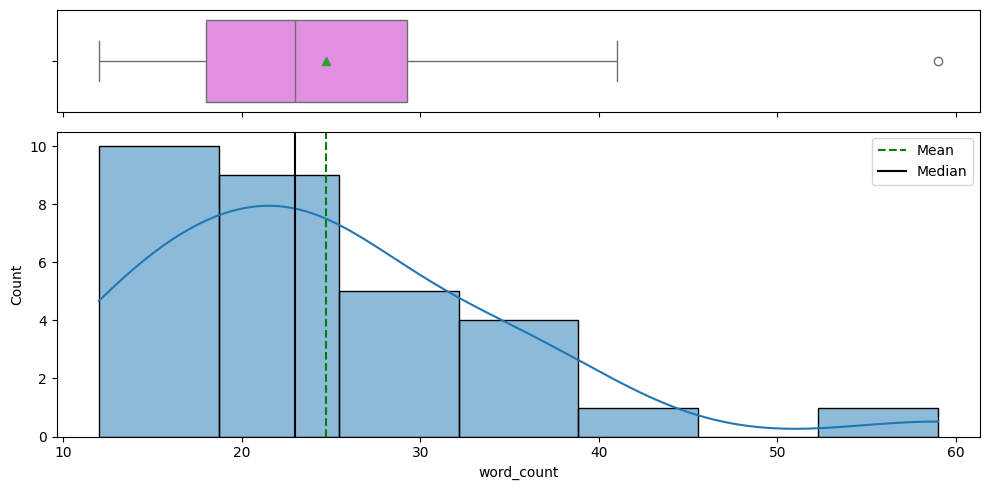

In [ ]:
# Distribution of word counts for full songs
print("Full Song Word Count Distribution")
histogram_boxplot(song_df, 'word_count', figsize=(10, 5), kde=True)

# Visualize the distribution of word counts for choruses
print("Chorus Word Count Distribution")
histogram_boxplot(chorus_df, 'word_count', figsize=(10, 5), kde=True)


**Observation:**

The full song word count distribution is moderately spread out, with most songs falling between 180 and 260 words, and one notable outlier at 600 words. The distribution is slightly right skewed due to that single long song. In contrast, chorus word counts are much more compact, ranging mostly between 18 and 30 words with no extreme outliers. This tight distribution indicates that choruses are not only shorter but also more consistent in length.

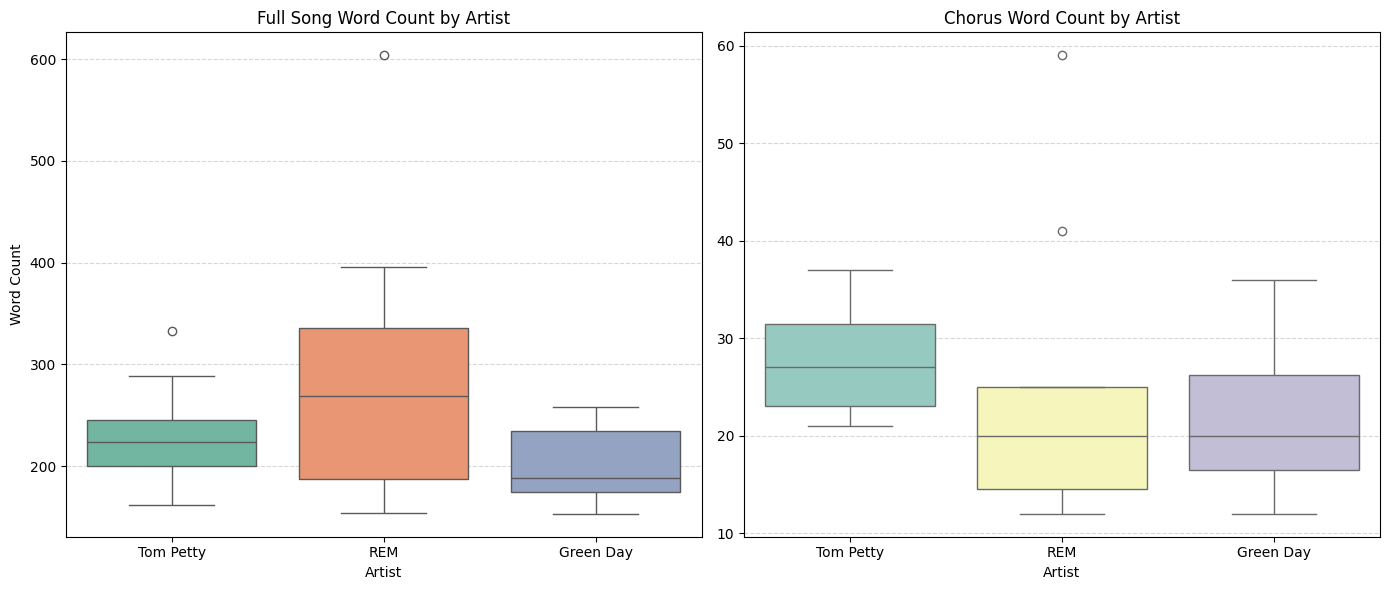

In [ ]:
# Create dual boxplots of word counts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Full song word count by artist
sns.boxplot(data=song_df, x='artist', y='word_count', palette='Set2', ax=axes[0])
axes[0].set_title('Full Song Word Count by Artist')
axes[0].set_xlabel('Artist')
axes[0].set_ylabel('Word Count')
axes[0].yaxis.grid(True, linestyle='--', alpha=0.5)

# Chorus word count by artist
sns.boxplot(data=chorus_df, x='artist', y='word_count', palette='Set3', ax=axes[1])
axes[1].set_title('Chorus Word Count by Artist')
axes[1].set_xlabel('Artist')
axes[1].set_ylabel('')  # Y-axis shared
axes[1].yaxis.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Observation:**

REM shows the widest range in full song word counts, with one outlier reaching over 600 words. Green Day's full songs tend to be shorter, while Tom Petty's fall somewhere in the middle, more consistent in length but with a moderate outlier. For choruses, the distributions tighten some with most falling in between 15-32 word range. REM again includes the longest outlier, while Tom Petty stay more compact. Choruses are shorter overall but also less variable across artists.

In [62]:
# Compute sentiment propotions for full songs
raw_song_sentiment_df = artist_sentiment(song_df)
raw_song_sentiment_df

,positive,neutral,negative
artist,,,
Green Day,0.3,0,0.7
REM,0.7,0,0.3
Tom Petty,0.9,0,0.1


In [63]:
# Compute sentiment proportions for choruses
raw_chorus_sentiment_df = artist_sentiment(chorus_df)
raw_chorus_sentiment_df

,positive,neutral,negative
artist,,,
Green Day,0.6,0.0,0.4
REM,0.4,0.3,0.3
Tom Petty,0.6,0.2,0.2


**Observation:**

Tom Petty's full songs show the highest concentration of positive sentiment at 0.9, followed by REM at 0.7 and Green Day 0.3. The highest negative sentiment is Green Day in their full lyrics at 0.7.

Choruses for all three artists appear more emotionally balanced. Green Day's choruses shift significantly, negative sentiment drops from by almost half, and positive sentiment doubles. REM's and Tom Petty's choruses also exhibit an increase in neutrality and a softening of polarity.

This pattern suggests that choruses tend to be more emotionally moderated compared to the full lyrical content, especially for artists like Green Day whose full songs lean heavily toward negative tone.

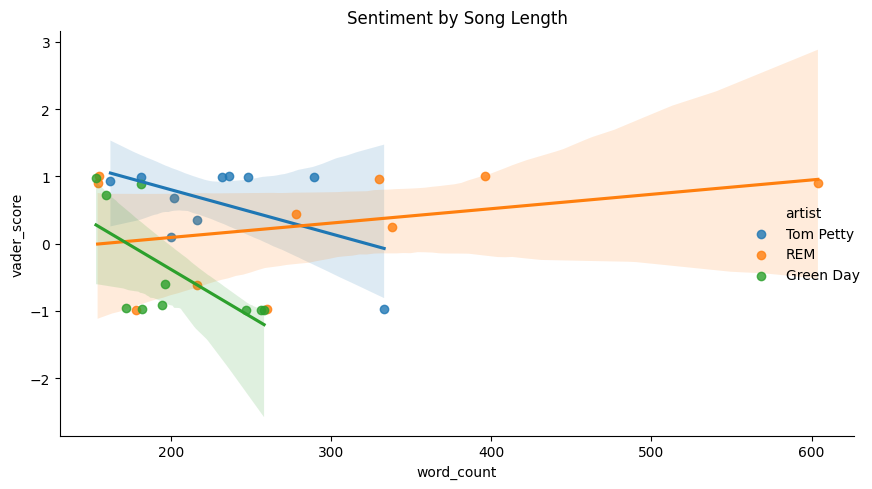

In [64]:
# Reapply word_count to song_df if needed
song_df['word_count'] = song_df['text'].apply(lambda x: len(x.split()))

# Apply VADER labels
labeled_songs = raw_vader_labels(song_df)

# Combine with word count
labeled_songs['word_count'] = song_df['word_count'].values

# Plot sentiment vs song length
sns.lmplot(data=labeled_songs, x='word_count', y='vader_score', hue='artist', aspect=1.5)
plt.title('Sentiment by Song Length')
plt.tight_layout()

**Observation:**

Sentiment varies with song length for each artist. Tom Petty shows a slightly negative trend, his shorter songs tend to be more positive, while the longer ones drift closer to neutral or even slightly negative. R.E.M. has a mild positive slope, suggesting that their longer songs could carry more emotional positivity, although with only a single represenative that long, it could be misleading. Green Day stands out with a clear downward trend, sentiment becomes increasingly negative as word count increases. This likely reflects their lyrical style, with more intense or critical themes emerging in longer tracks.

These patterns indicate that artists differ in tone, but those differences can shift depending the length they take to deliver their message.

### **Count Vectorization and Document-Term Matrix**

In [65]:
# Baseline Vectorization (Before Cleaning & Stopword Removal)
vect = CountVectorizer()

# Raw full songs
X_counts_raw = vect.fit_transform(combined_df['text'])
dtm_raw_song = pd.DataFrame(X_counts_raw.toarray(), columns=vect.get_feature_names_out())
dtm_raw_song.index = combined_df['song_title']

# Raw chorus
X_chorus_raw = vect.fit_transform(combined_df['chorus'])
dtm_raw_chorus = pd.DataFrame(X_chorus_raw.toarray(), columns=vect.get_feature_names_out())
dtm_raw_chorus.index = combined_df['song_title']

# Display full song
dtm_raw_song.head()

,21,441,aaah,abandon,ability,about,accuser,across,adding,aeroplane,...,ya,yard,yeah,years,you,young,your,yours,yourself,yuh
song_title,,,,,,,,,,,,,,,,,,,,,
Free Fallin',0,0,0,0,0,0,0,0,0,0,...,0,1,4,0,0,0,0,0,0,0
I Won't Back Down,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
American Girl,0,1,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
Learning to Fly,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,0,0
You Don't Know How It Feels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,13,1,0,0,0,0


In [ ]:
# Display chorus
dtm_raw_chorus.head()

,21,about,across,adding,agents,ain,alienation,all,alone,alright,...,wings,without,won,wonder,workin,world,would,yeah,you,your
song_title,,,,,,,,,,,,,,,,,,,,,
Free Fallin',0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
I Won't Back Down,0,0,0,0,0,1,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
American Girl,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,1,0,0
Learning to Fly,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
You Don't Know How It Feels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


**Explanation:**

This section creates baseline document term matrices or DTMs for both full song lyrics and choruses using raw text. The CountVectorizer tokenizes each lyric into individual words and builds a matrix where each row represents a song and columns a unique word across the corpus, indicating how many times each word appears in each song or chorus. These are raw and constructed before any cleaning, such as removing stopwords or lowercasing.

**Observation:**

The matrices reveal the disparity in vocabulary size between full songs and choruses. Full songs generate 1,061 unique terms, compared to only 264 terms in the chorus matrix. This is corresponds with choruses repeating lyrics, creating a smaller word list.

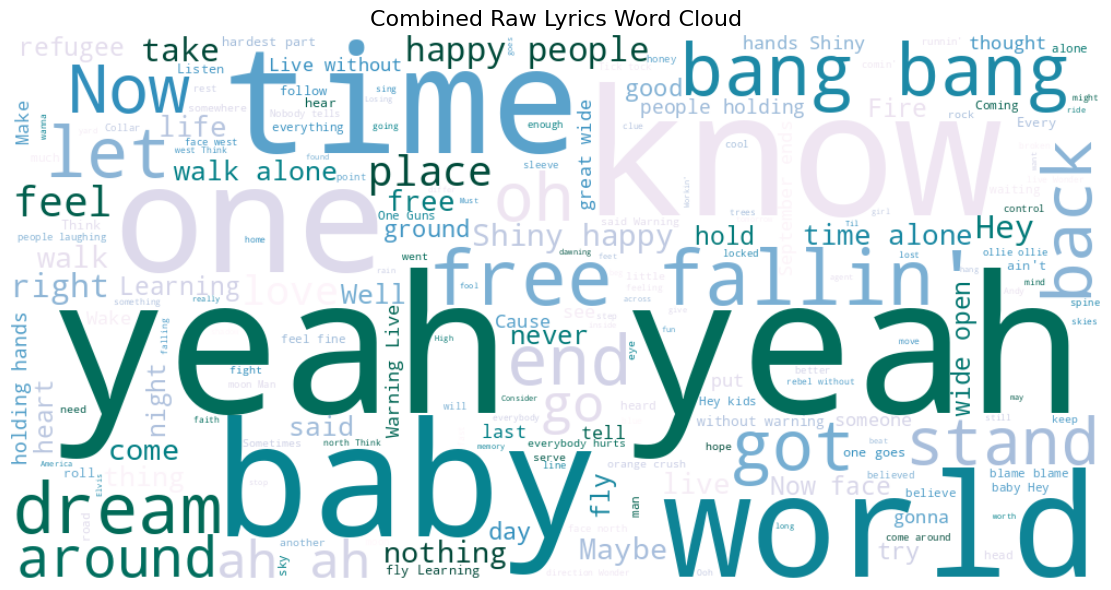

In [ ]:
# Generate a word cloud from the all raw lyrics
overall_wordcloud(combined_df, text_col='text', title='Combined Raw Lyrics Word Cloud')

**Observation:**

The raw lyrics word cloud highlights emotionally charged and thematically central words. Terms like yeah, baby, know, one, and world  dominate the visualization, reflecting the more conversational, and emotional tone typical of rock and pop lyrics. Repetition of affirmations, references to relationships, and introspective expressions suggest a consistent lyrical focus across the artists.

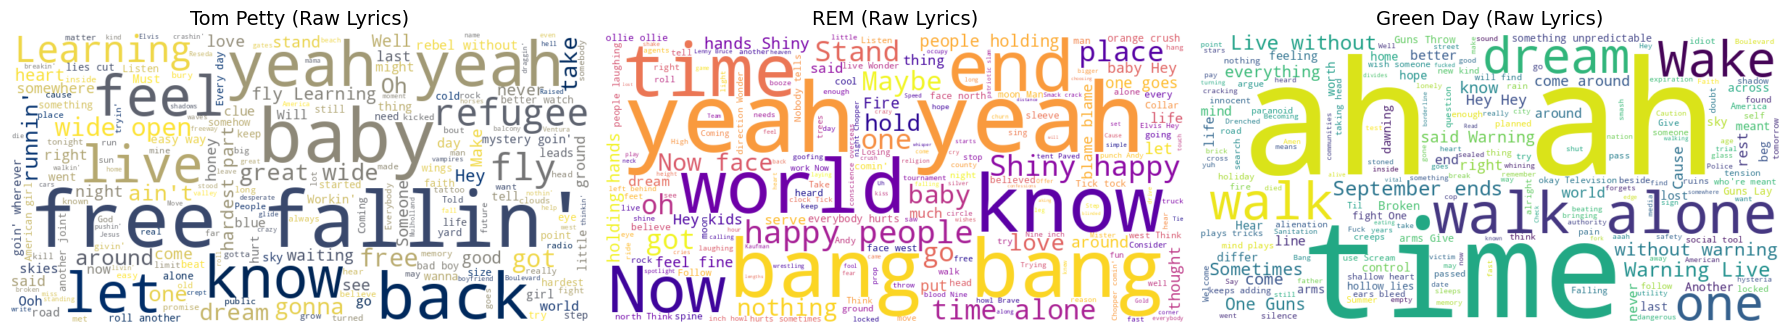

In [ ]:
# Generate a word cloud from raw lyrics by artist
artist_wordclouds(combined_df, text_col='text', title_suffix='(Raw Lyrics)')

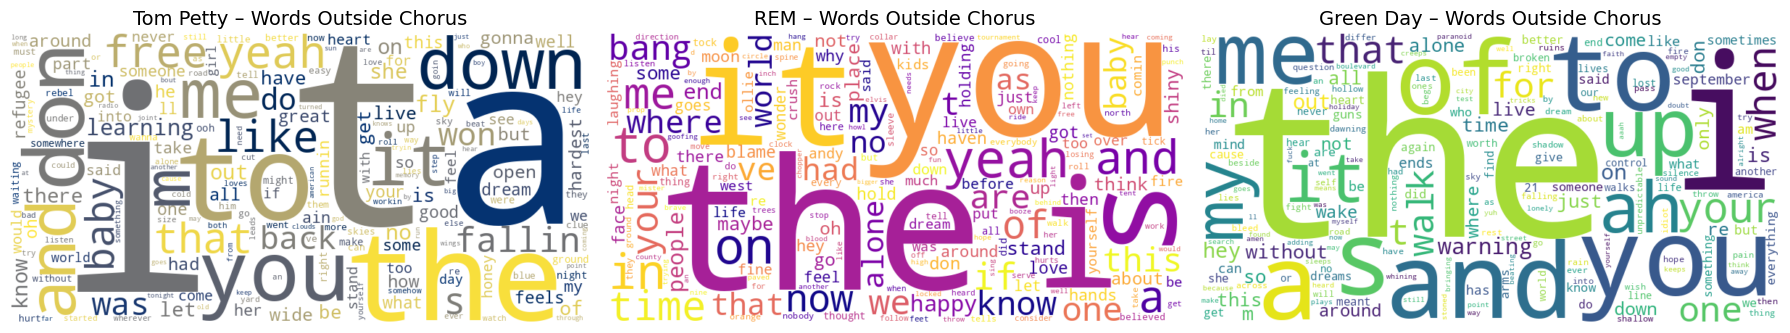

In [ ]:
# Generate a word cloud by artist on the words that are not in both the chorus and song
artist_diff_freqs = artist_nonchorus_diff_freqs(combined_df)
plot_artist_diff_wordclouds(artist_diff_freqs, title_suffix="– Words Outside Chorus")

**Observation:**

The word clouds show both lyrical focus and style tendencies across the three artists. In the raw lyrics, Tom Petty's cloud highlights recurring imagery like free, fallin', back, wide, and dream, suggesting open spaces and introspection. R.E.M. leans heavily on repetition with standout words like bang, yeah, and world, which mirror their punchy and abstract style. Green Day's word cloud is dominated by ah, time, alone, and wake, pointing to more rhythmic or emotional phrases, often tied to isolation or urgency.

The second set focuses on only words outside the chorus, showing a shift. Common words like the, and, and to dominate all three, but Tom Petty's unique terms like fallin', free, and refugee re-emerge, showing that meaningful storytelling happens outside the chorus. R.E.M.'s still echo bang, world, and you, with consistent abstract and layered messaging. Green Day's set again indicating that their songs outside the chorus often drive home personal or time based themes.

###**Text Preprocessing and Vectorizing**

In [66]:
# Base English and custom stopwords
my_stop_words = stopwords.words('english')
my_stop_words += ['yeah', 'oh', 'gonna', 'na', 'uh', 'woah', 'la', 'ah', 'ha',
                  'get', 'got', 'make', 'go', 'like', 'let', 'know', 'one', 'hey']

# Vectorize full songs using the custom stopword list
vectorizer_song = CountVectorizer(
    stop_words=my_stop_words,
    max_features=50,
    ngram_range=(1, 1),
    lowercase=True
)

X_song = vectorizer_song.fit_transform(combined_df['text'])
vocab_song = vectorizer_song.get_feature_names_out()
dtm_song = pd.DataFrame(X_song.toarray(), columns=vocab_song)
dtm_song.index = combined_df['song_title']

# Vectorize choruses using the custom stopword list
vectorizer_chorus = CountVectorizer(
    stop_words=my_stop_words,
    max_features=50,
    ngram_range=(1, 1),
    lowercase=True
)

X_chorus = vectorizer_chorus.fit_transform(combined_df['chorus'])
vocab_chorus = vectorizer_chorus.get_feature_names_out()
dtm_chorus = pd.DataFrame(X_chorus.toarray(), columns=vocab_chorus)
dtm_chorus.index = combined_df['song_title']

dtm_song.head()

,alone,around,baby,back,bang,blame,come,dream,end,everybody,...,stand,take,thing,think,time,walk,warning,well,without,world
song_title,,,,,,,,,,,,,,,,,,,,,
Free Fallin',0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
I Won't Back Down,0,2,4,21,0,0,0,0,0,0,...,7,0,0,0,0,0,0,2,0,2
American Girl,1,0,2,1,0,0,0,0,0,0,...,0,2,0,0,0,0,0,2,0,1
Learning to Fly,1,2,0,0,0,0,2,0,0,0,...,0,0,3,0,0,0,0,3,0,1
You Don't Know How It Feels,1,0,0,0,0,0,1,1,0,0,...,0,1,0,1,0,0,0,0,0,0


In [ ]:
dtm_chorus.head()

,alone,baby,back,bang,blame,come,dream,end,everybody,fallin,...,shiny,sometimes,take,think,thought,time,walk,warning,without,world
song_title,,,,,,,,,,,,,,,,,,,,,
Free Fallin',0,0,0,0,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0
I Won't Back Down,0,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
American Girl,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Learning to Fly,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
You Don't Know How It Feels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Explanation:**

CountVectorizer was used to isolate meaningful language from the corpus and remove a custom stop word list built on top of NLTK's English stopwords. The additions included song specific noncontent words like that are common in lyrics but don't contribute much to interpretation. By setting max_features=50, output was limited to the most prominent unigrams, ensuring focus on dominant language patterns. This vectorization was applied separately to the full songs and the choruses, to retain structural distinction.

**Observation:**

The song and chorus outputs, indicate the full songs contain richer and more diverse language than the choruses. As an example, the song, I Won't Back Down shows 21 uses of the word 'back' and 7 uses of 'stand' in the full lyrics, while the chorus only surfaces one instance of 'back.' You can also see more repetition in the chorus.

###**Clustering Trials**

In [67]:
# Full Song DTM
print("Full Songs:")
print(type(dtm_song))
print(dtm_song.shape)

# Convert to NumPy array for clustering
X_matrix_song = dtm_song.values
print(type(X_matrix_song))
print(X_matrix_song)

# Chorus DTM
print("\nChorus:")
print(type(dtm_chorus))
print(dtm_chorus.shape)

# Convert to NumPy array for clustering
X_matrix_chorus = dtm_chorus.values
print(type(X_matrix_chorus))
print(X_matrix_chorus)

Full Songs:
<class 'pandas.core.frame.DataFrame'>
(30, 50)
<class 'numpy.ndarray'>
[[ 0  0  0 ...  0  0  1]
 [ 0  2  4 ...  2  0  2]
 [ 1  0  2 ...  2  0  1]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  3  3]
 [ 0  0  0 ...  0 12  0]]

Chorus:
<class 'pandas.core.frame.DataFrame'>
(30, 50)
<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 1 3 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 4 3 0]]


**Explanantion:**

Data preparation for clustering DTMs from the previous vectorization were converted into NumPy arrays. This transformation allows for compatibility with clustering algorithms, which require input in array format. The .values attribute is used to extract the underlying matrix from the pandas DataFrame, producing clean, dense NumPy arrays that retain the unigram frequencies for each song and chorus. These arrays serve as the foundation for all downstream unsupervised modeling.

In [68]:
# Run KMeans on full song DTM
kmeans_song = KMeans(n_clusters=3, random_state=42)
kmeans_song.fit(X_matrix_song)
labels_song = kmeans_song.labels_

results_song_df = pd.DataFrame({
    'song': dtm_song.index,
    'artist': combined_df['artist'],
    'cluster': labels_song
})

results_song_df.head()

,song,artist,cluster
0,Free Fallin',Tom Petty,2
1,I Won't Back Down,Tom Petty,1
2,American Girl,Tom Petty,1
3,Learning to Fly,Tom Petty,1
4,You Don't Know How It Feels,Tom Petty,1


In [69]:
# Run KMeans on chorus DTM
kmeans_chorus = KMeans(n_clusters=3, random_state=42)
kmeans_chorus.fit(X_matrix_chorus)
labels_chorus = kmeans_chorus.labels_

results_chorus_df = pd.DataFrame({
    'song': dtm_chorus.index,
    'artist': combined_df['artist'],
    'cluster': labels_chorus
})

results_chorus_df.head()

,song,artist,cluster
0,Free Fallin',Tom Petty,2
1,I Won't Back Down,Tom Petty,1
2,American Girl,Tom Petty,1
3,Learning to Fly,Tom Petty,1
4,You Don't Know How It Feels,Tom Petty,1


**Explanation:**

This applies KMeans clustering to the vectorized full song data and choruses to identify groups of songs with similar language use. The number of clusters is set to 3 because of the known presence of 3 artists.

###**Initial Cluster Results**

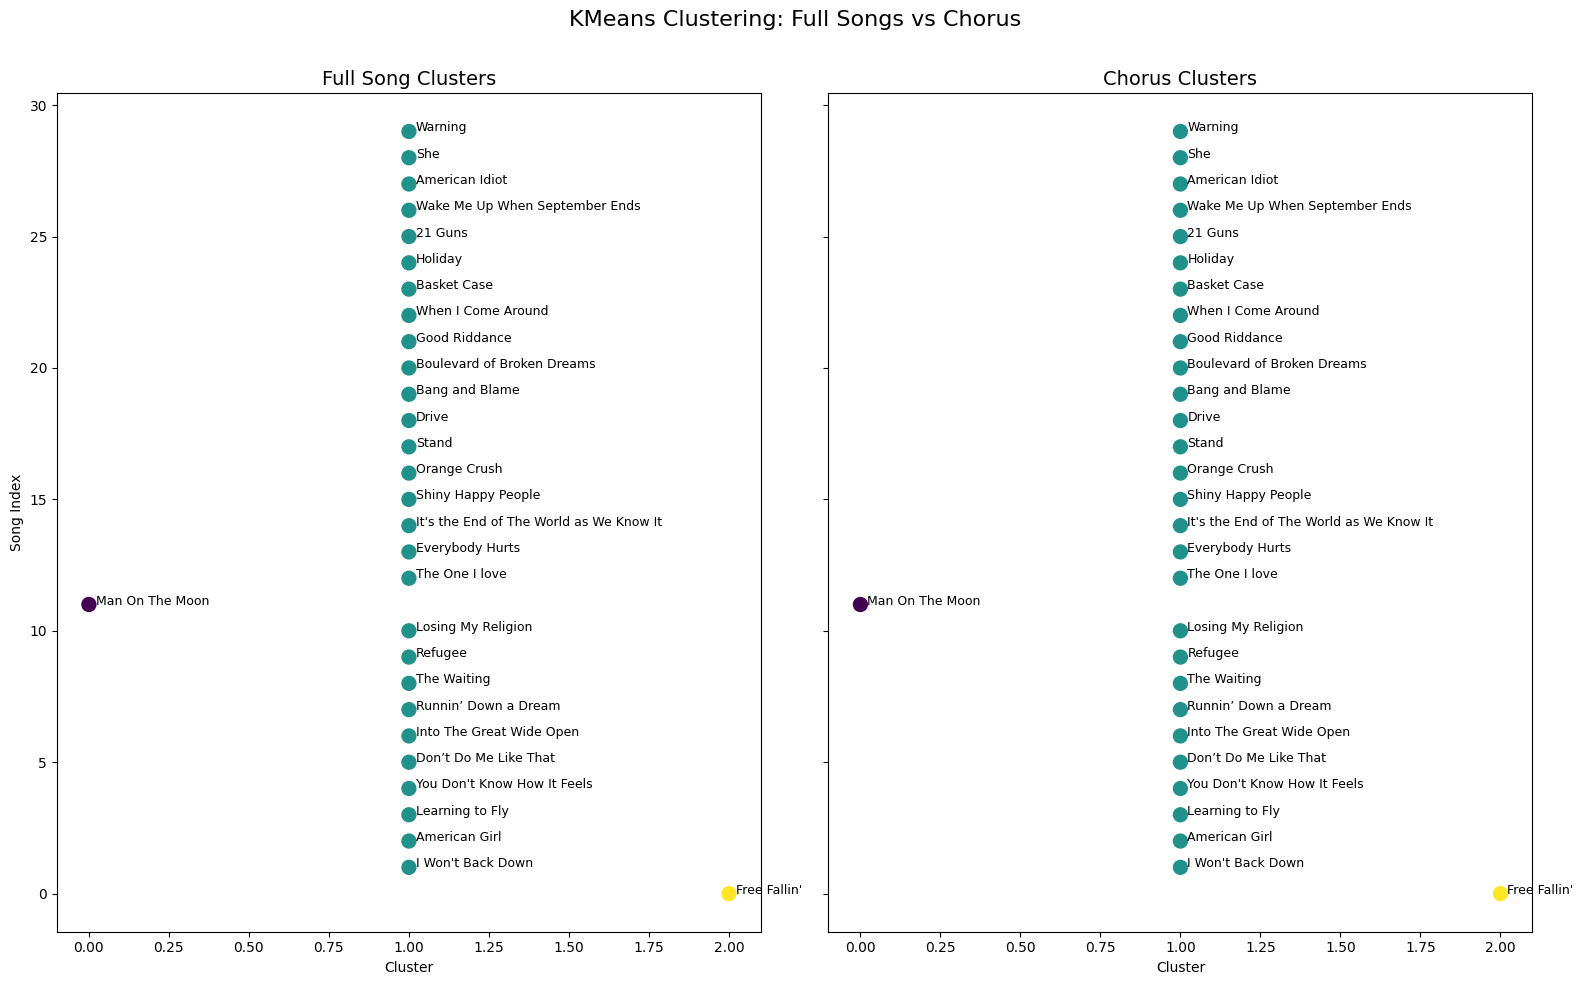

In [70]:
# Create plots for comparing clustering results
fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=True)

# Full song clusters and index
axes[0].scatter(results_song_df['cluster'], results_song_df.index,
                c=results_song_df['cluster'], cmap='viridis', s=100)

for i, txt in enumerate(results_song_df['song']):
    axes[0].annotate(txt, (results_song_df['cluster'].iloc[i], i),
                     textcoords="offset points", xytext=(5, 0), ha='left', fontsize=9)

axes[0].set_title("Full Song Clusters", fontsize=14)
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Song Index")

# Chorus clusters and index
axes[1].scatter(results_chorus_df['cluster'], results_chorus_df.index,
                c=results_chorus_df['cluster'], cmap='viridis', s=100)

for i, txt in enumerate(results_chorus_df['song']):
    axes[1].annotate(txt, (results_chorus_df['cluster'].iloc[i], i),
                     textcoords="offset points", xytext=(5, 0), ha='left', fontsize=9)

axes[1].set_title("Chorus Clusters", fontsize=14)
axes[1].set_xlabel("Cluster")

plt.suptitle("KMeans Clustering: Full Songs vs Chorus", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

**Observation:**

The clustering reveals two clear outliers Free Fallin' and Man On The Moon, both consistently fall into distinct clusters for both the full song and chorus models. This suggests that these songs use language patterns or themes that sharply diverge from the rest of the corpus. The remaining songs form a dominant cluster, reinforcing shared stylistic or lexical patterns across all artists. There is a stong agreement between full and chorus structures in how songs are written, while still allowing room for lyrics that stand out.

###**Tfidf Vectorizer**

In [71]:
# Initialize lemmatizer to reduce words to root form
lemmatizer = WordNetLemmatizer()

# Filter defined stop words
cleaned_songs = []
cleaned_choruses = []

# Iteratively clean corpuses independently
for _, row in combined_df.iterrows():
    # Full song
    tokens_song = re.findall(r'\b\w+\b', str(row['text']).lower())
    filtered_song = [lemmatizer.lemmatize(word) for word in tokens_song if word.isalpha() and word not in my_stop_words]
    cleaned_songs.append(" ".join(filtered_song))

    # Chorus
    tokens_chorus = re.findall(r'\b\w+\b', str(row['chorus']).lower())
    filtered_chorus = [lemmatizer.lemmatize(word) for word in tokens_chorus if word.isalpha() and word not in my_stop_words]
    cleaned_choruses.append(" ".join(filtered_chorus))

combined_df['song_clean'] = cleaned_songs
combined_df['chorus_clean'] = cleaned_choruses

**Explanation:**

Lemmatization was applied to both the full songs and choruses after removing stopwords and non alphabetic tokens, reducing to its root form, preserving the semantic meaning, and reducing dimensionality. Regular expressions were used for clean tokenization, and a custom stop word list was removed. Creating a normalized, content-heavy language, increasing interpretability across both types of sections.

In [72]:
# Initialize stemmer to reduce words to stem form
stemmer = PorterStemmer()

# Define tokenizer with punctuation removal, stemming, and to lower
def stemmed_tokenizer(text):
    tokens = nltk.word_tokenize(text.lower())
    no_punct_tokens = [word for word in tokens if word.isalpha()]
    stemmed = [stemmer.stem(word) for word in no_punct_tokens]
    return stemmed

# TF-IDF vectorizer for song
tfidf_vectorizer_song = TfidfVectorizer(
    tokenizer=stemmed_tokenizer,
    stop_words=my_stop_words,
    max_features=50,
    lowercase=True
)
# TF-IDF vectorizer for chorus
tfidf_vectorizer_chorus = TfidfVectorizer(
    tokenizer=stemmed_tokenizer,
    stop_words=my_stop_words,
    max_features=50,
    lowercase=True
)

# Fit vectorizers and transform cleaned text into TF-IDF matrices
X_tfidf_song = tfidf_vectorizer_song.fit_transform(combined_df['song_clean'])
X_tfidf_chorus = tfidf_vectorizer_chorus.fit_transform(combined_df['chorus_clean'])

# Convert the TF-IDF matrices into labeled df
dtm_tfidf_song = pd.DataFrame(X_tfidf_song.toarray(), columns=tfidf_vectorizer_song.get_feature_names_out())
dtm_tfidf_song.index = combined_df['song_title']

dtm_tfidf_chorus = pd.DataFrame(X_tfidf_chorus.toarray(), columns=tfidf_vectorizer_chorus.get_feature_names_out())
dtm_tfidf_chorus.index = combined_df['song_title']

# Check structure
print(dtm_tfidf_song.shape)
print(dtm_tfidf_chorus.shape)

(30, 50)
(30, 50)


**Explanation:**

To capture normalized patterns in language across lyrics, TF-IDF vectorization was applied to both full songs and choruses using a custom tokenizer that includes stemming. This compresses inflected and related words down to the root, reducing redundancy and enhancing redundancy and enhance feature relevance. The tokenizer strips punctuation, enforces lowercase, and applies a stemmer before vectorization. A max_features cap of 50 was kept to focus on dominant terms.

###**Final Cluster Results**

In [73]:
# Convert to NumPy array for clustering
X_matrix_song = dtm_tfidf_song.values
print(type(X_matrix_song))
print(X_matrix_song.shape)

# Run KMeans on song
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_matrix_song)
labels = kmeans.labels_

results_df = pd.DataFrame({
    'song': dtm_tfidf_song.index,
    'artist': combined_df['artist'],
    'cluster': labels
})

results_df.head()

<class 'numpy.ndarray'>
(30, 50)


,song,artist,cluster
0,Free Fallin',Tom Petty,1
1,I Won't Back Down,Tom Petty,1
2,American Girl,Tom Petty,1
3,Learning to Fly,Tom Petty,1
4,You Don't Know How It Feels,Tom Petty,2


In [74]:
# Convert to NumPy array for clustering
X_matrix_chorus = dtm_tfidf_chorus.values
print(type(X_matrix_chorus))
print(X_matrix_chorus.shape)

# Run KMeans on song
kmeans_chorus = KMeans(n_clusters=3, random_state=42)
kmeans_chorus.fit(X_matrix_chorus)
chorus_labels = kmeans_chorus.labels_

results_chorus_df = pd.DataFrame({
    'song': dtm_tfidf_chorus.index,
    'artist': combined_df['artist'],
    'cluster': chorus_labels
})

results_chorus_df.head()

<class 'numpy.ndarray'>
(30, 50)


,song,artist,cluster
0,Free Fallin',Tom Petty,0
1,I Won't Back Down,Tom Petty,2
2,American Girl,Tom Petty,1
3,Learning to Fly,Tom Petty,0
4,You Don't Know How It Feels,Tom Petty,1


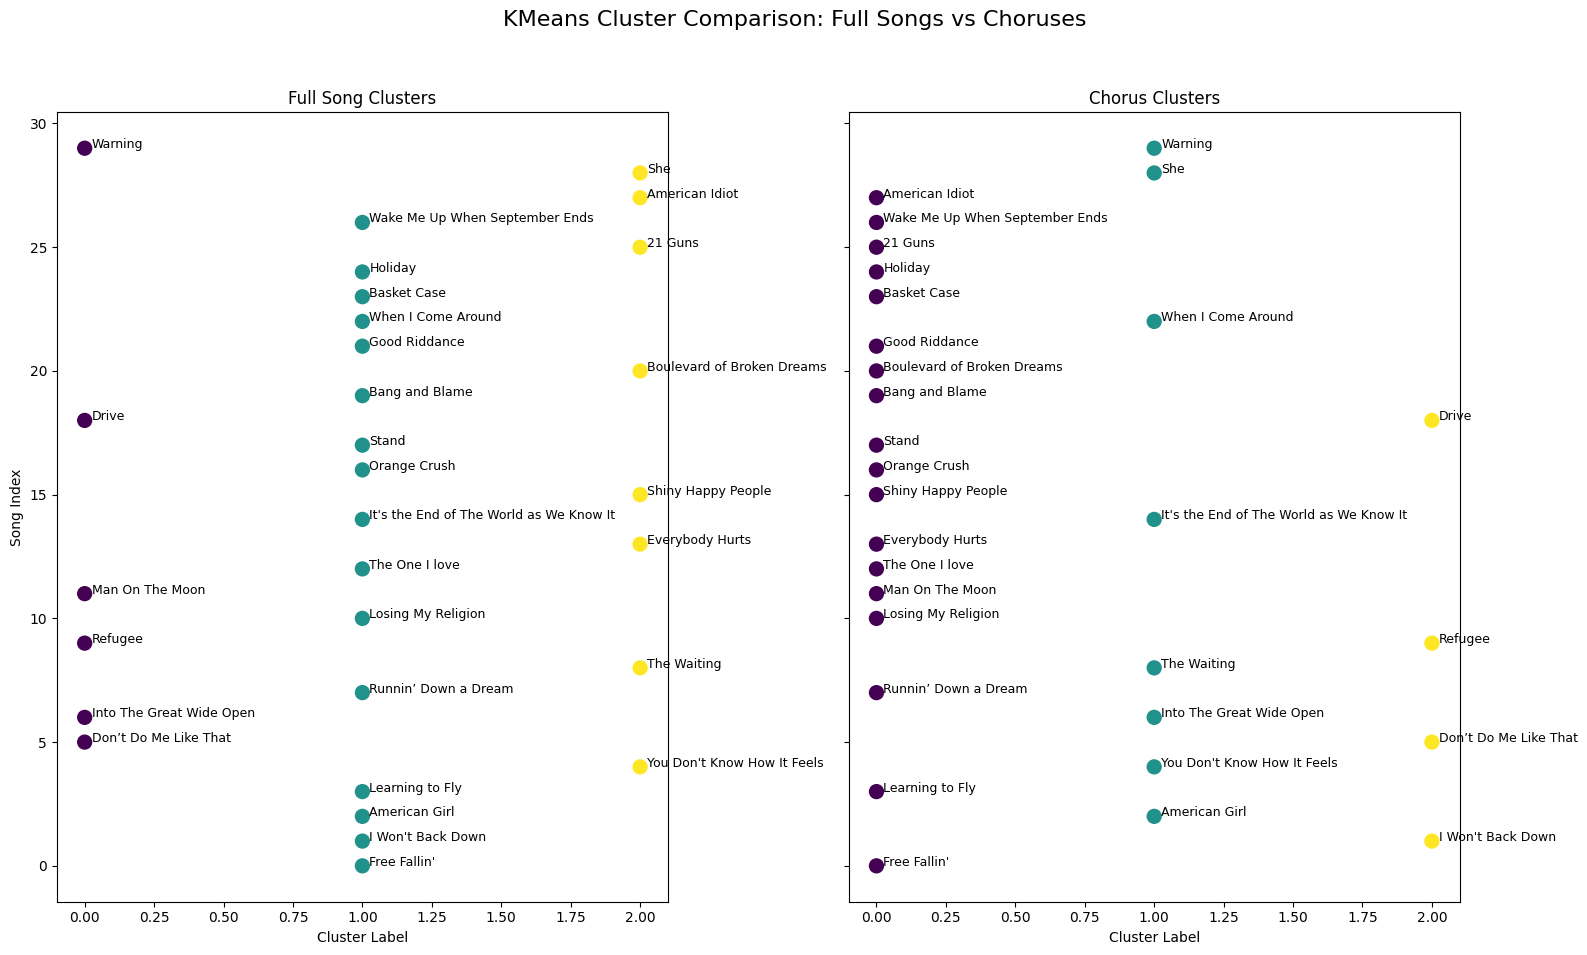

In [76]:
# Create plots for comparing clustering results
fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=True)

# Full song clusters and index
axes[0].scatter(results_df['cluster'], results_df.index,
                c=results_df['cluster'], cmap='viridis', s=100)

for i, txt in enumerate(results_df['song']):
    axes[0].annotate(txt,
                     (results_df['cluster'].iloc[i], i),
                     textcoords="offset points",
                     xytext=(5, 0),
                     ha='left', fontsize=9)

axes[0].set_xlabel("Cluster Label")
axes[0].set_ylabel("Song Index")
axes[0].set_title("Full Song Clusters")

# Chorus clusters and index
axes[1].scatter(results_chorus_df['cluster'], results_chorus_df.index,
                c=results_chorus_df['cluster'], cmap='viridis', s=100)

for i, txt in enumerate(results_chorus_df['song']):
    axes[1].annotate(txt,
                     (results_chorus_df['cluster'].iloc[i], i),
                     textcoords="offset points",
                     xytext=(5, 0),
                     ha='left', fontsize=9)

axes[1].set_xlabel("Cluster Label")
axes[1].set_title("Chorus Clusters")

plt.suptitle("KMeans Cluster Comparison: Full Songs vs Choruses", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Observation:**

The updated KMeans clustering results using TF-IDF and stemming reveal a more nuanced separation of lyrical patterns between full songs and choruses. Changes include, 'Drive' and 'Refugee' are now distinct in the chorus. This suggests their choruses rely on a narrower or more stylistically unique set of stemmed words. In contrast, the majority of songs by Green Day and R.E.M. now cluster more tightly in the full song view, showing stronger intra-group consistency once inflectional differences are stripped away. Stemming enhanced grouping by collapsing variations, allowing clearer grouping of structurally similar songs.

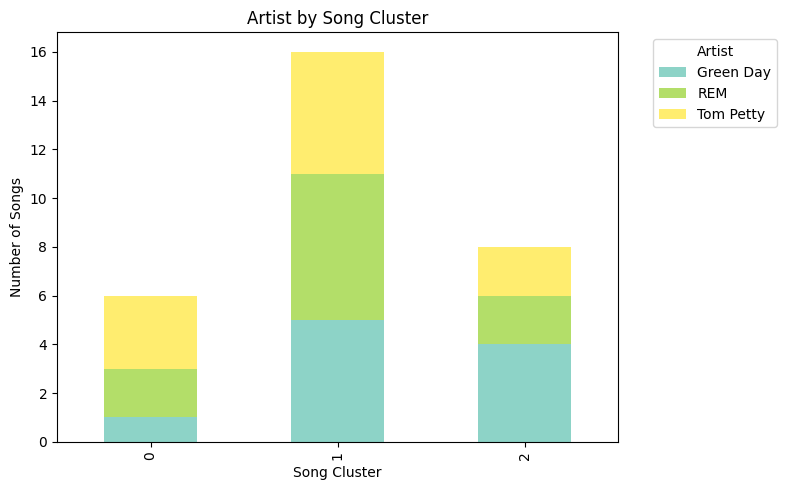

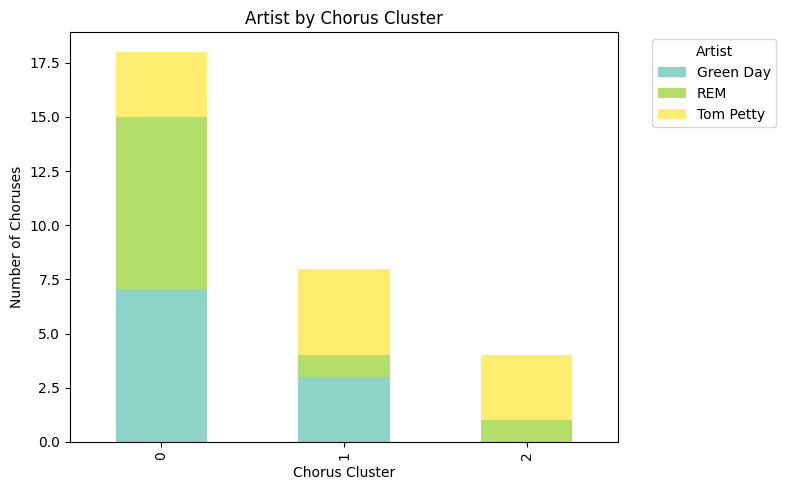

In [79]:
# Song cluster artist distribution
results_df.groupby(['cluster', 'artist']).size().unstack(fill_value=0).plot(
    kind='bar', stacked=True, figsize=(8,5), colormap='Set3')
plt.title("Artist by Song Cluster")
plt.xlabel("Song Cluster")
plt.ylabel("Number of Songs")
plt.legend(title="Artist", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Chorus cluster artist distribution
results_chorus_df.groupby(['cluster', 'artist']).size().unstack(fill_value=0).plot(
    kind='bar', stacked=True, figsize=(8,5), colormap='Set3')
plt.title("Artist by Chorus Cluster")
plt.xlabel("Chorus Cluster")
plt.ylabel("Number of Choruses")
plt.legend(title="Artist", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Observation:**

Artist distribution comparison by clusters show a shift in clustering dynamics once the focus narrows to the chorus. In the full song view, all three artists are represented fairly evenly across clusters, with Cluster 1 being the most densely populated and balanced. However, in the chorus clustering, Cluster 0 becomes dominant and skews heavily toward R.E.M., suggesting their choruses share more linguistic or structural overlap. And Tom Petty's choruses are more evenly split across all clusters, indicating broader variation in his refrains relative to his verses. This contrast suggests chorus focused clustering can amplify stylistic or lexical patterns that might be diluted in full song analysis.

In [85]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Compute compound sentiment scores for full songs and choruses
combined_df['song_sentiment'] = combined_df['text'].apply(lambda x: sid.polarity_scores(str(x))['compound'])
combined_df['chorus_sentiment'] = combined_df['chorus'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

# Build a sentiment summary
song_sentiment_df = combined_df[['song_title', 'artist', 'song_sentiment', 'chorus_sentiment']]

# Merge in full song
song_sentiment_df = song_sentiment_df.merge(results_df[['song', 'cluster']], left_on='song_title', right_on='song')
song_sentiment_df = song_sentiment_df.rename(columns={'cluster': 'song_cluster'})

# Merge in the chorus
song_sentiment_df = song_sentiment_df.merge(results_chorus_df[['song', 'cluster']], on='song', suffixes=('', '_chorus'))
song_sentiment_df = song_sentiment_df.rename(columns={'cluster_chorus': 'chorus_cluster'})

# Group by cluster and calculate mean sentiment
cluster_sentiment_summary = song_sentiment_df.groupby('song_cluster')[['song_sentiment', 'chorus_sentiment']].mean().round(3)
cluster_sentiment_summary['delta'] = cluster_sentiment_summary['song_sentiment'] - cluster_sentiment_summary['chorus_sentiment']
cluster_sentiment_summary

,song_sentiment,chorus_sentiment,delta
song_cluster,,,
0,0.072,0.253,-0.181
1,0.265,0.194,0.071
2,-0.049,0.084,-0.133


**Observation:**

Cluster 1 stands out with the highest positivity in full song sentiment at 0.265, with choruses slightly less positive at 0.194. Clusters 0 and 2 have stronger positive sentiment in their choruses than in the full lyrics, as indicated by negative deltas. The most pronounced shift is in Cluster 0, where chorus sentiment jumps to 0.253 while the rest of the song remains more neutral at 0.072. This indicates that songs in Cluster 0, the emotional core may be concentrated in the chorus, while Cluster 1 maintains a generally upbeat tone throughout. Cluster 2, by contrast, contains the most negative songs overall, with both skewing negative.

### **Modeling and Performance Comparison**

In [87]:
# Define function for classification
def run_logistic_regression(X, y, label=""):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize and train model
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = clf.predict(X_test)
    print(f"{label} Classification Report")
    print(classification_report(y_test, y_pred))

# Run for full songs
run_logistic_regression(dtm_tfidf_song.values, results_df['cluster'], label="Full Song")

# Run for choruses
run_logistic_regression(dtm_tfidf_chorus.values, results_chorus_df['cluster'], label="Chorus")

Full Song Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.44      1.00      0.62         4
           2       0.00      0.00      0.00         4

    accuracy                           0.44         9
   macro avg       0.15      0.33      0.21         9
weighted avg       0.20      0.44      0.27         9

Chorus Classification Report
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.50      0.67         2
           2       0.00      0.00      0.00         1

    accuracy                           0.78         9
   macro avg       0.58      0.50      0.51         9
weighted avg       0.72      0.78      0.72         9



**Explanation:**

Classification on the clustering labels provides a diagnostic step to test how well the TF-IDF features capture the underlying structure that KMeans identified. While the clustering is unsupervised, using a supervised classifier on the same features with those labels allows for indirect validation of the feature space. If the classifier performs well, it suggests that the clusters are not arbitrary, that they reflect meaningful separation in the language patterns extracted from the songs or choruses. On the other hand, poor performance would indicate that the clusters may not be well supported by the text representations, or that additional preprocessing and or dimensionality reduction is needed. This check bridges the gap between unsupervised grouping and interpretable, testable classification.

**Observation:**

The classification results reveal a clear contrast in how well the model performed on full songs versus choruses. For the full songs, performance was poor across the board, with an overall accuracy of just 0.44. The model was only able to predict Cluster 1  with any success, and even that came at the cost of completely missing the other two. This may reflect noise or redundancy in the full lyric content, where repeated words or filler dominate the feature set. In contrast, the classification of choruses performed noticeably better, with an accuracy of 0.78 and solid precision and recall for Cluster 0. While the sample size was small, this suggests that the chorus sections carried more distinct or learnable patterns, likely due to their role as thematic and emotional focal points of a song.

###**Export data**

In [92]:
# Complete song and chorus dataset
combined_df.to_csv("petty_rem_greenday.csv", index=False)
files.download("petty_rem_greenday.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Conclusion**

This fun project explored how thematic language and sentiment diverge between full song lyrics and their choruses using a combination of text mining techniques, vectorization, clustering, and classification. The dataset was manually constructed to preserve structural integrity between each song and its corresponding chorus, enabling direct comparison. Through careful preprocessing, custom stopword filtering, and TF-IDF representation, the lyrical content was reduced to its most essential and interpretable terms. KMeans clustering on both full songs and choruses revealed some alignment, but also meaningful variation in how songs are grouped based on the language used in the most emotionally charged segments.

Thematic analysis across the choruses showed a concentration of emotionally potent, action driven language that often differed from the broader narrative arcs presented in full lyrics. This was supported by sentiment scoring, where choruses frequently showed distinct sentiment values relative to their parent songs. These shifts were not random; they aligned with the known function of the chorus as the emotional anchor or hook. Clustering patterns, particularly when visualized together, confirmed that songs with similar full text did not always align in chorus grouping, indicating that artists may use choruses to depart from or intensify their intended narrative.

The final classification task reinforced this distinction. While full song classification suffered from noise and redundancy in language, chorus classification produced stronger predictive results, indicating that the chorus structure carries more consistent and learnable linguistic signals. This analysis highlights how songwriters craft chorus sections to distill emotion and message, often leveraging different linguistic strategies than in the surrounding verses. For text mining applications, especially in music or entertainment analytics, this reinforces the importance of examining structural components independently to capture deeper thematic and emotional variance.

“It's something unpredictable, but in the end it’s right.” --Green Day, *Good Riddance*